In [1]:
import os
import numpy as np
import itertools as itt
from functools import partial
import sklearn

from scipy.stats import uniform

from sklearn.model_selection import train_test_split, ShuffleSplit, RandomizedSearchCV, learning_curve
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import classification_report, accuracy_score, precision_recall_curve
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

import matplotlib.pyplot as plt
from pprint import pprint

In [2]:
np.random.seed(7)

In [3]:
def plot_learning_curve(estimator, x, y, ylim=None, **kwargs):
    
    plt.figure()
    if ylim is not None:
        plt.ylim(*ylim)
        
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, x, y, **kwargs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std  = np.std(train_scores, axis=1)
    test_scores_mean  = np.mean(test_scores, axis=1)
    test_scores_std   = np.std(test_scores, axis=1)
    
    plt.grid()
    
    plt.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r"
    )
    plt.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g"
    )
    
    plt.plot(
        train_sizes, train_scores_mean, 'o-',
        color="r",
        label="Training score"
    )
    plt.plot(
        train_sizes, test_scores_mean, 'o-',
        color="g",
        label="Validation score"
    )

    plt.legend(loc="best")
    
    plt.show()

In [4]:
def plot_precision_recall_curve(y_true, y_pred):
    
    precision_curve, recall_curve, _ = precision_recall_curve(y_true, y_pred)
    step_kwargs = (
        {'step': 'post'} if 'step' in sklearn.utils.fixes.signature(plt.fill_between).parameters else {}
    )
    
    plt.step(
        recall_curve, precision_curve,
        color='b',
        alpha=0.2,
        where='post'
    )
    
    plt.fill_between(
        recall_curve, precision_curve,
        alpha=0.2,
        color='b', 
        **step_kwargs
    )

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    
    plt.title('Precision-Recall curve')
    
    plt.show()

In [5]:
def start_section(title, line_sep="-" * 100):
    print(title, end="\n{}\n".format(line_sep))
    
def end_section(line_sep="-" * 100):
    start_section("", line_sep=line_sep)

In [6]:
DefaultTfidfVectorizer = partial(
    TfidfVectorizer,
    input="content", analyzer="word", stop_words="english", token_pattern="[^ ]+",
    ngram_range=(1, 3)
)

In [7]:
root = "/media/spiros/Data/lingspam_public/bare"

In [8]:
ham, spam = [], []

for dirpath, _, filenames in os.walk(root):
    for filename in filenames:
        with open(os.path.join(dirpath, filename), encoding="utf8") as file:
            message = file.read()
        if filename.startswith("spm"):
            spam.append(message)
        else:
            ham.append(message)
            
print("Ham: {}, Spam: {}".format(len(ham), len(spam)))

Ham: 2412, Spam: 481


In [9]:
x = ham + spam
y = [0] * len(ham) + [1] * len(spam)

train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.3)

In [10]:
def train_pipeline(pipeline, x, y):
    
    start_section("Learning Curve")
    plot_learning_curve(pipeline, x, y, cv=ShuffleSplit(n_splits=3, test_size=0.1), n_jobs=7)
    
    return pipeline.fit(x, y)

def evaluate_pipeline(pipeline, x, y_true):
    y_pred = pipeline.predict(x)
    
    start_section("Classification Report")
    print(classification_report(y_true, y_pred, target_names=["Ham", "Spam"]), end="\n\n")
    print("Accuracy: {}".format(accuracy_score(y_true, y_pred)), end="\n\n")
    
    start_section("Precision-Recall Curve")
    plot_precision_recall_curve(y_true, y_pred)
    
    return pipeline

def get_tuned_pipeline_params(pipeline, param_distributions={}, n_iter=10):
    
    cross_validator = RandomizedSearchCV(
        pipeline, param_distributions,
        n_iter=n_iter,
        scoring="f1",
        cv=ShuffleSplit(n_splits=3, test_size=0.1),
        n_jobs=7,
        refit=False
    )
    cross_validator.fit(train_x, train_y)
    
    best_params = cross_validator.best_params_
    
    start_section("Best Hyperparameters")
    pprint(best_params)
    
    return best_params

def run_pipeline(pipeline, param_distributions={}, n_iter=10):
    
    if len(param_distributions):    
        start_section("Hyperparameter Tuning")
        pipeline.set_params(**get_tuned_pipeline_params(pipeline, param_distributions, n_iter))
        end_section()
    
    start_section("Training")
    pipeline = train_pipeline(pipeline, train_x, train_y)
    end_section()
    
    start_section("Evaluation")
    pipeline = evaluate_pipeline(pipeline, test_x, test_y)
    end_section()

<h2>Dummy Classifier</h2>
It predicts the most frequent class.

Training
----------------------------------------------------------------------------------------------------
Learning Curve
----------------------------------------------------------------------------------------------------


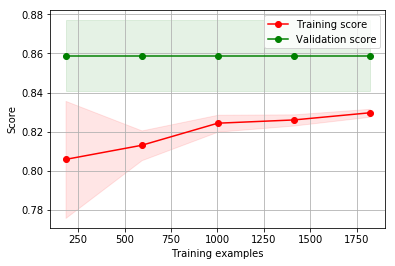


----------------------------------------------------------------------------------------------------
Evaluation
----------------------------------------------------------------------------------------------------
Classification Report
----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

         Ham       0.84      1.00      0.91       726
        Spam       0.00      0.00      0.00       142

   micro avg       0.84      0.84      0.84       868
   macro avg       0.42      0.50      0.46       868
weighted avg       0.70      0.84      0.76       868


Accuracy: 0.836405529953917

Precision-Recall Curve
----------------------------------------------------------------------------------------------------


/home/spiros/env/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


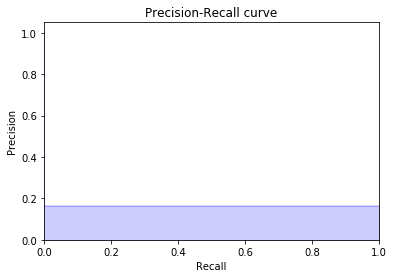


----------------------------------------------------------------------------------------------------


In [11]:
import sklearn.dummy

pipeline = make_pipeline(
    DefaultTfidfVectorizer(max_features=1000),
    sklearn.dummy.DummyClassifier(strategy="most_frequent")
)
param_distributions = {
    "multinomialnb__alpha": uniform()
}

run_pipeline(pipeline)

<h2>Multinomial Naive Bayes</h2>

Hyperparameter Tuning
----------------------------------------------------------------------------------------------------
Best Hyperparameters
----------------------------------------------------------------------------------------------------
{'multinomialnb__alpha': 0.07152046013477242}

----------------------------------------------------------------------------------------------------
Training
----------------------------------------------------------------------------------------------------
Learning Curve
----------------------------------------------------------------------------------------------------


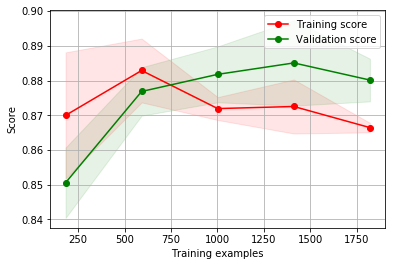


----------------------------------------------------------------------------------------------------
Evaluation
----------------------------------------------------------------------------------------------------
Classification Report
----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

         Ham       0.88      1.00      0.93       726
        Spam       0.97      0.27      0.43       142

   micro avg       0.88      0.88      0.88       868
   macro avg       0.93      0.64      0.68       868
weighted avg       0.89      0.88      0.85       868


Accuracy: 0.880184331797235

Precision-Recall Curve
----------------------------------------------------------------------------------------------------


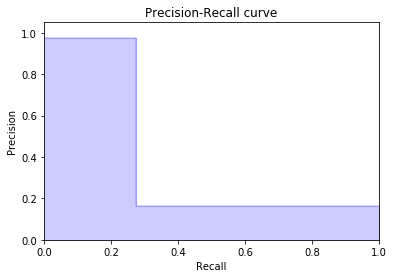


----------------------------------------------------------------------------------------------------


In [12]:
import sklearn.naive_bayes

pipeline = make_pipeline(
    DefaultTfidfVectorizer(max_features=2500),
    SelectKBest(mutual_info_classif, k=100),
    sklearn.naive_bayes.MultinomialNB()
)
param_distributions = {
    "multinomialnb__alpha": uniform()
}

run_pipeline(pipeline, param_distributions=param_distributions, n_iter=50)

<h2>Logistic Regression</h2>

In [ ]:
import sklearn.linear_model

pipeline = make_pipeline(
    DefaultTfidfVectorizer(sublinear_tf=True),
    TruncatedSVD(n_components=100),
    sklearn.linear_model.LogisticRegression(class_weight="balanced", solver="liblinear")
)
param_distributions = {
    "logisticregression__C": uniform()
}

run_pipeline(pipeline, param_distributions=param_distributions, n_iter=20)

Hyperparameter Tuning
----------------------------------------------------------------------------------------------------


<h2>Random Forest Classifier</h2>

In [ ]:
import sklearn.ensemble

pipeline = make_pipeline(
    DefaultTfidfVectorizer(max_features=2500),
    SelectKBest(mutual_info_classif, k=100),
    sklearn.ensemble.RandomForestClassifier(criterion="entropy", n_jobs=7, class_weight="balanced_subsample")
)
param_distributions = {
    "randomforestclassifier__n_estimators": [10, 100],
    "randomforestclassifier__max_depth": [1, None],
    "randomforestclassifier__min_weight_fraction_leaf": uniform(0.25, 0.25),
    "randomforestclassifier__max_features": uniform()
}

run_pipeline(pipeline, param_distributions=param_distributions, n_iter=50)

<h2>K-Neighbors Classifier</h2>

In [ ]:
import sklearn.neighbors

pipeline = make_pipeline(
    DefaultTfidfVectorizer(sublinear_tf=True),
    TruncatedSVD(n_components=100),
    sklearn.neighbors.KNeighborsClassifier(n_jobs=7)
)
param_distributions = {
    "kneighborsclassifier__p": [1, 2],
    "kneighborsclassifier__weights": ["uniform", "distance"],
    "kneighborsclassifier__n_neighbors": list(range(1, 20, 2))
}

run_pipeline(pipeline, param_distributions=param_distributions, n_iter=20)

<h2>Linear Support Vector Classifier</h2>

In [ ]:
import sklearn.svm

pipeline = make_pipeline(
    DefaultTfidfVectorizer(sublinear_tf=True),
    TruncatedSVD(n_components=100),
    sklearn.svm.LinearSVC(dual=False, class_weight="balanced")
)
param_distributions = {
    "linearsvc__penalty": ["l1", "l2"],
    "linearsvc__C": uniform()
}

run_pipeline(pipeline, param_distributions=param_distributions, n_iter=20)